In [91]:
import os
from dotenv import load_dotenv, find_dotenv

load_dotenv(find_dotenv())

API_KEYS = ['LANGCHAIN_API_KEY', 'OPENAI_API_KEY', 'LANGCHAIN_TRACING_V2', 'LANGCHAIN_ENDPOINT', 
            'LANGCHAIN_PROJECT', 'TAVILY_API_KEY', 'GROQ_API_KEY']
for api_key in API_KEYS:
    os.environ[api_key] = os.getenv(api_key)

### Web Scraping Agent

In [167]:
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
import operator
from typing import Annotated
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.document_loaders import ArxivLoader
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma

model = ChatOpenAI()
vector_db = Chroma(embedding_function=OpenAIEmbeddings())

class ResearchStateInput(TypedDict):
    question: str
    content: Annotated[list, operator.add]
    new_questions: list

class ResearchState(TypedDict):
    question: str
    flattened_docs: list
    summary: str
    citations: list
    fact_check: str
    errors: list = []


def get_user_input(state: ResearchStateInput):
    return {'question': state['question']}

def wikiloader(state: ResearchStateInput):
    """To load the information from Wikipedia based on the user input question."""

    question = state['question']
    wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
    wiki_result = wikipedia.run(question)
    doc = Document(page_content=wiki_result, metadata={"source": "Wikipedia", "title": question})
    return {'content': [doc]}

def arxiv_loader(state: ResearchStateInput):
    """To load the information from Arxiv based on the user input question."""

    question = state['question']
    arxiv = ArxivLoader(
                        query=question,
                        load_max_docs=2)
    content = arxiv.load()

    return {'content': [content]}

def query_translation(state: ResearchStateInput):
    """To translate user input queries into better queries/questions that can be used to retrieve information from the web."""

    question = state['question']
    query_translation_prompt = """You are expert at translating user input queries into a better queries/questions that 
                        can be used to retrieve information from the web. Here is your user-input question: {question}\n
                        Output (2 queries):"""

    question_template = query_translation_prompt.format(question=question)
    response = model.invoke(question_template)

    return {'new_questions': response.content.split('\n')}

def tavily_search_docs(state: ResearchStateInput):
    """To search the web for the information based on the translated queries/questions and get the url details."""
    
    result_doc = []
    new_questions = state['new_questions']
    web_search_prompt = """You are expert at retrieving information from the web. 
                        You are asked to find the following information: {question}"""

    tavily = TavilySearchResults(max_results=1)
    for question in new_questions:
        prompt = web_search_prompt.format(question=question)
        tavily_search = tavily.invoke({'query': prompt})
        result_doc.extend([Document(page_content=tavily['content'], metadata={"source": tavily['url'], "title": question}) 
                            for tavily in (tavily_search)])
        
    return {'content': result_doc}

def retrieve(state: ResearchStateInput)->ResearchState:
    content = state['content']
    question = state['question']

    flattened_docs = [item for sublist in content for item in (sublist if isinstance(sublist, list) else [sublist])]
    vector = vector_db.add_documents(flattened_docs)

    return {'flattened_docs': flattened_docs, 'question': question}


def summarization(state: ResearchState):
    """To summarize the retrieved information from the web."""
    flattened_docs = state['flattened_docs']
    question = state['question']

    summarization_llm = ChatOpenAI(model="gpt-4o-mini")

    summarization_prompt = """You are expert at summarizing the retrieved information from the different sources. 
                            You are asked to summarize the following information and retain the citations: {documents}"""

    summarization_prompt = summarization_prompt.format(documents=flattened_docs)

    try:
        response = model.invoke(summarization_prompt)
    except Exception as _:
        response = summarization_llm.invoke(summarization_prompt)

    citations = [doc.metadata.get('source', 'Arxiv') for doc in flattened_docs]
    return {'summary': response.content, 'citations': list(set(citations))}

def fact_check_agent(state: ResearchState):
    """To fact-check the summarized information."""
    summary = state['summary']

    fact_check_prompt = """You are expert at fact-checking the summarized information. 
                        You are asked to fact-check the following information: {summary}"""

    fact_check_prompt = fact_check_prompt.format(summary=summary)
    response = model.invoke(fact_check_prompt)

    return {'fact_check': response.content}

def error_detection_agent(state: ResearchState):
    """To detect the errors in the fact-checked information."""
    fact_check = state['fact_check']
    errors = []

    if "conflicting" in fact_check.lower():
        errors.append("Conflict identified in the fact-checked information.")

    return {'errors': errors}

def error_checker(state: ResearchState):
    errors = state['errors']
    
    if errors:
        return ['get_user_input']

    return END
    

query_modifier({'errors': ['present'], 'question': 'Attention is all you need', 'summary': out['summary']})

# tavily_search_docs({'new_questions': ['What is Attention is all you need?']})
# wk = wikiloader({'question': 'Attention mechanism'})
# ar = arxiv_loader({'question': 'Attention mechanism'})


{'question': 'What are some recent advancements in attention mechanisms within machine learning and how do they enhance model performance across various domains?'}

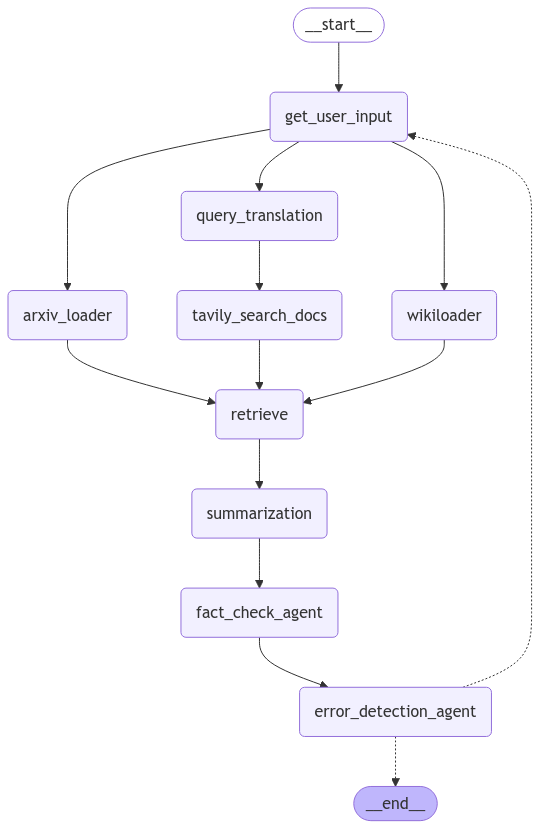

In [168]:
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

builder = StateGraph(ResearchStateInput, output=ResearchState)
builder.add_node('get_user_input', get_user_input)
builder.add_node('wikiloader', wikiloader)
builder.add_node('arxiv_loader', arxiv_loader)
builder.add_node('query_translation', query_translation)
builder.add_node('tavily_search_docs', tavily_search_docs)
builder.add_node('retrieve', retrieve)
builder.add_node('summarization', summarization)
builder.add_node('fact_check_agent', fact_check_agent)
builder.add_node('error_detection_agent', error_detection_agent)

builder.add_edge(START, 'get_user_input')
builder.add_edge('get_user_input', 'wikiloader')
builder.add_edge('get_user_input', 'arxiv_loader')
builder.add_edge('get_user_input', 'query_translation')
builder.add_edge('query_translation', 'tavily_search_docs')

builder.add_edge('arxiv_loader', 'retrieve')
builder.add_edge('wikiloader', 'retrieve')
builder.add_edge('tavily_search_docs', 'retrieve')
builder.add_edge('retrieve', 'summarization')
builder.add_edge('summarization', 'fact_check_agent')
builder.add_edge('fact_check_agent', 'error_detection_agent')

builder.add_conditional_edges('error_detection_agent', error_checker, ['get_user_input', END])

graph = builder.compile()
Image(graph.get_graph(xray=1).draw_mermaid_png())


In [169]:
out = graph.invoke({'question':'Attention is all you need'})

In [170]:
out

{'question': 'Attention is all you need',
 'flattened_docs': [Document(metadata={'Published': '2024-07-22', 'Title': "Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models", 'Authors': 'Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini', 'Summary': 'The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter laye

In [171]:
print(out['summary'])

Here's a summarized version of the provided information regarding the various documents related to attention mechanisms in machine learning, specifically in the context of transformer architectures:

1. **"Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models" (Tyukin et al., 2024)**: This paper addresses the increasing demand for inference in large language models (LLMs) while highlighting the challenges posed by the quadratic complexity of attention mechanisms in transformer architectures. The authors investigate how dropping specific attention and MLP layers during inference can improve efficiency with minimal impact on performance. For instance, removing 33% of attention layers in a Llama-v2 model results in only a 1.8% decrease in average performance but significantly enhances speed. They conclude that greater efficiency can be achieved without sacrificing quality (Tyukin et al., 2024).

2. **"All the Attention You Need: Global-Local, Spatia

### Summarization Agent

In [136]:
out['flattened_docs']

[Document(metadata={'Published': '2024-07-22', 'Title': "Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models", 'Authors': 'Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini', 'Summary': 'The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for 

In [78]:
ar

{'content': [[Document(metadata={'Published': '2022-03-27', 'Title': 'A General Survey on Attention Mechanisms in Deep Learning', 'Authors': 'Gianni Brauwers, Flavius Frasincar', 'Summary': 'Attention is an important mechanism that can be employed for a variety of\ndeep learning models across many different domains and tasks. This survey\nprovides an overview of the most important attention mechanisms proposed in the\nliterature. The various attention mechanisms are explained by means of a\nframework consisting of a general attention model, uniform notation, and a\ncomprehensive taxonomy of attention mechanisms. Furthermore, the various\nmeasures for evaluating attention models are reviewed, and methods to\ncharacterize the structure of attention models based on the proposed framework\nare discussed. Last, future work in the field of attention models is\nconsidered.'}, page_content='1\nA General Survey on Attention Mechanisms in\nDeep Learning\nGianni Brauwers and Flavius Frasincar\nAb

In [173]:
import os
from dotenv import load_dotenv, find_dotenv
from langchain_community.tools.tavily_search import TavilySearchResults
from typing_extensions import TypedDict
from langchain_openai import ChatOpenAI, OpenAIEmbeddings
from langchain_community.document_loaders import WebBaseLoader
import operator
from typing import Annotated, List
from langchain_community.tools import WikipediaQueryRun
from langchain_community.utilities import WikipediaAPIWrapper
from langchain_community.document_loaders import ArxivLoader
from langchain_core.documents import Document
from langchain_community.vectorstores import Chroma
from langgraph.graph import StateGraph, START, END
import streamlit as st
from langchain_core.runnables import RunnablePassthrough

load_dotenv(find_dotenv())

API_KEYS = ['LANGCHAIN_API_KEY', 'OPENAI_API_KEY', 'LANGCHAIN_TRACING_V2', 'LANGCHAIN_ENDPOINT', 
            'LANGCHAIN_PROJECT', 'TAVILY_API_KEY', 'GROQ_API_KEY']
for api_key in API_KEYS:
    os.environ[api_key] = os.getenv(api_key)

# st.title("🔍 Multi-Agent Research Assistant")
# user_question = st.text_input("Enter your research topic:")

model = ChatOpenAI()
vector_db = Chroma(embedding_function=OpenAIEmbeddings())

class ResearchStateInput(TypedDict):
    question: str
    

class ResearchState(TypedDict):
    question: str
    flattened_docs: list
    summary: str
    citations: list
    fact_check: str
    errors: list = []
    content: Annotated[list, operator.add]
    new_questions: list
    vector: List[Document]

class ResearchStateOutput(TypedDict):
    flattened_docs: str
    summary: str
    vector: List[Document]
    flattened_docs: list

def get_user_input(state: ResearchStateInput):
    return {'question': state['question']}

def wikiloader(state: ResearchStateInput)->ResearchState:
    """To load the information from Wikipedia based on the user input question."""

    question = state['question']
    wikipedia = WikipediaQueryRun(api_wrapper=WikipediaAPIWrapper())
    wiki_result = wikipedia.run(question)
    doc = Document(page_content=wiki_result, metadata={"source": "Wikipedia", "title": question})
    return {'content': [doc]}

def arxiv_loader(state: ResearchStateInput)->ResearchState:
    """To load the information from Arxiv based on the user input question."""

    question = state['question']
    arxiv = ArxivLoader(
                        query=question,
                        load_max_docs=2)
    content = arxiv.load()

    return {'content': [content]}

def query_translation(state: ResearchStateInput)->ResearchState:
    """To translate user input queries into better queries/questions that can be used to retrieve information from the web."""

    question = state['question']
    query_translation_prompt = """You are expert at translating user input queries into a better queries/questions that 
                        can be used to retrieve information from the web. Here is your user-input question: {question}\n
                        Output (2 queries):"""

    question_template = query_translation_prompt.format(question=question)
    response = model.invoke(question_template)

    return {'new_questions': response.content.split('\n')}

def tavily_search_docs(state: ResearchState):
    """To search the web for the information based on the translated queries/questions and get the url details."""
    
    result_doc = []
    new_questions = state['new_questions']
    web_search_prompt = """You are expert at retrieving information from the web. 
                        You are asked to find the following information: {question}"""

    tavily = TavilySearchResults(max_results=1)
    for question in new_questions:
        prompt = web_search_prompt.format(question=question)
        tavily_search = tavily.invoke({'query': prompt})
        result_doc.extend([Document(page_content=tavily['content'], metadata={"source": tavily['url'], "title": question}) 
                            for tavily in (tavily_search)])
        
    return {'content': result_doc}

def retrieve(state: ResearchState):
    content = state['content']
    question = state['question']

    flattened_docs = [item for sublist in content for item in (sublist if isinstance(sublist, list) else [sublist])]
    vector = vector_db.add_documents(flattened_docs)

    return {'flattened_docs': flattened_docs, 'question': question, 'vector': vector}


def summarization(state: ResearchState):
    """To summarize the retrieved information from the web."""
    flattened_docs = state['flattened_docs']
    question = state['question']

    summarization_llm = ChatOpenAI(model="gpt-4o-mini")

    summarization_prompt = """You are expert at summarizing the retrieved information from the different sources. 
                            You are asked to summarize the following information and retain the citations: {documents}"""

    summarization_prompt = summarization_prompt.format(documents=flattened_docs)

    try:
        response = model.invoke(summarization_prompt)
    except Exception as _:
        response = summarization_llm.invoke(summarization_prompt)

    citations = [doc.metadata.get('source', 'Arxiv') for doc in flattened_docs]
    return {'summary': response.content, 'citations': list(set(citations))}

def fact_check_agent(state: ResearchState):
    """To fact-check the summarized information."""
    summary = state['summary']

    fact_check_prompt = """You are expert at fact-checking the summarized information. 
                        You are asked to fact-check the following information: {summary}"""

    fact_check_prompt = fact_check_prompt.format(summary=summary)
    response = model.invoke(fact_check_prompt)

    return {'fact_check': response.content}

def error_detection_agent(state: ResearchState):
    """To detect the errors in the fact-checked information."""
    fact_check = state['fact_check']
    errors = []

    if "conflicting" in fact_check.lower():
        errors.append("Conflict identified in the fact-checked information.")

    return {'errors': errors}

def error_checker(state: ResearchState)->ResearchStateOutput:
    errors = state['errors']
    
    if errors:
        return ['get_user_input']

    return END

def rag_result(question, document):
    prompt = """Generate answer of the given question: {question} based on the following summary and document: {summary} 
                Also adding full document: {document}"""

    retriever = vector.as_retriever(search_kwargs = {'k': 1})

    rag_chain = ({'context': retriever, 'question': RunnablePassthrough()}
                | prompt
                | model
                | StrOutputParser())
    
    return rag_chain.invoke(question)
        

builder = StateGraph(ResearchStateInput, output=ResearchState)
builder.add_node('get_user_input', get_user_input)
builder.add_node('wikiloader', wikiloader)
builder.add_node('arxiv_loader', arxiv_loader)
builder.add_node('query_translation', query_translation)
builder.add_node('tavily_search_docs', tavily_search_docs)
builder.add_node('retrieve', retrieve)
builder.add_node('summarization', summarization)
builder.add_node('fact_check_agent', fact_check_agent)
builder.add_node('error_detection_agent', error_detection_agent)

builder.add_edge(START, 'get_user_input')
builder.add_edge('get_user_input', 'wikiloader')
builder.add_edge('get_user_input', 'arxiv_loader')
builder.add_edge('get_user_input', 'query_translation')
builder.add_edge('query_translation', 'tavily_search_docs')

builder.add_edge('arxiv_loader', 'retrieve')
builder.add_edge('wikiloader', 'retrieve')
builder.add_edge('tavily_search_docs', 'retrieve')
builder.add_edge('retrieve', 'summarization')
builder.add_edge('summarization', 'fact_check_agent')
builder.add_edge('fact_check_agent', 'error_detection_agent')

builder.add_conditional_edges('error_detection_agent', error_checker, ['get_user_input', END])

graph = builder.compile()



result = graph.invoke({'question':f'Attention is all you need'})

    

In [174]:
result

{'question': 'Attention is all you need',
 'flattened_docs': [Document(metadata={'Published': '2024-07-22', 'Title': "Attention Is All You Need But You Don't Need All Of It For Inference of Large Language Models", 'Authors': 'Georgy Tyukin, Gbetondji J-S Dovonon, Jean Kaddour, Pasquale Minervini', 'Summary': 'The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter laye

In [222]:
from langchain_core.runnables import RunnablePassthrough
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate

def rag_result(question, document, summary):
    template = """Generate answer of the given question: {question} \n based on the following summary: {summary} \n
                Also adding full document: {document}"""

    document = "\n".join([doc.metadata.get('Summary', '') if 'Summary' in doc.metadata else doc.page_content for doc in document ])
    # prompt = prompt.format(summary=result['summary'], document=document)
    prompt = ChatPromptTemplate.from_template(template)
    # print(prompt)
    llm = ChatOpenAI(model="gpt-4o-mini")
    rag_chain =  (RunnablePassthrough().bind(
                    question=RunnablePassthrough(),
                    summary=RunnablePassthrough(),
                    document=RunnablePassthrough()
                ) 
                | prompt
                | llm
                | StrOutputParser())

    return rag_chain

    return rag_chain

In [223]:
import asyncio

followup = "What are the 3 advantages of attention?"
rag_model = rag_result(followup, result['flattened_docs'], result['summary'])

async def stream_response():
    response_placeholder = st.empty()
    full_response = ""

    async for chunk in rag_model.astream({
        'question': followup, 
        'document': result['flattened_docs'], 
        'summary': result['summary']
    }):
        full_response += chunk  # Accumulate streamed content
        response_placeholder.write(full_response)  # Update Streamlit UI in real time

await (stream_response())

2025-02-01 00:34:28.316 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 00:34:28.317 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 00:34:32.090 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 00:34:32.098 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 00:34:32.104 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 00:34:32.105 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 00:34:32.107 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2025-02-01 00:34:32.107 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bar

In [204]:
"\n".join([doc.metadata.get('Summary', '') if 'Summary' in doc.metadata else doc.page_content for doc in result['flattened_docs'] ])

'The inference demand for LLMs has skyrocketed in recent months, and serving\nmodels with low latencies remains challenging due to the quadratic input length\ncomplexity of the attention layers. In this work, we investigate the effect of\ndropping MLP and attention layers at inference time on the performance of\nLlama-v2 models. We find that dropping dreeper attention layers only marginally\ndecreases performance but leads to the best speedups alongside dropping entire\nlayers. For example, removing 33\\% of attention layers in a 13B Llama2 model\nresults in a 1.8\\% drop in average performance over the OpenLLM benchmark. We\nalso observe that skipping layers except the latter layers reduces performances\nfor more layers skipped, except for skipping the attention layers.\nWe address representation learning for large-scale instance-level image\nretrieval. Apart from backbone, training pipelines and loss functions, popular\napproaches have focused on different spatial pooling and attenti

In [201]:
result['flattened_docs'][4].page_content

'In just 3 minutes help us improve arXiv: cs arXiv:2501.05730v1 arXiv author ID The next-generation architecture, aiming at retaining the competitive performance of SA while achieving low-cost inference and efficient long-sequence training, primarily focuses on three approaches: linear attention, linear RNNs, and state space models. Furthermore, the element-wise attention circumvents the performance degradation factors present in these approaches and achieves performance comparable to SA in both causal and non-causal forms. Subjects:   Machine Learning (cs.LG); Artificial Intelligence (cs.AI) Cite as:    arXiv:2501.05730 [cs.LG] (or arXiv:2501.05730v1 [cs.LG] for this version) From: Guoxin Feng [view email] Access Paper: cs.LG cs cs.AI References & Citations Bibliographic and Citation Tools Bibliographic Explorer Toggle Connected Papers Toggle Which authors of this paper are endorsers? arXiv Operational Status '